## EECS-545 Project
# SHAP values
last date modified: 12/9/2021

use 15 features
corrections: -remove all ones-mask (in adition to all-zeros mask) -use weight from the paper, eq.8

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from scipy.special import comb
from copy import deepcopy

## Functions

In [2]:
# Truncate data columns to max 15
class Dataset:
    def __init__(self, data, y):
        numrc_cols = []
        for col, val in zip((data.dtypes!="object").index,data.dtypes!="object"):
            if val == True:
                numrc_cols.append(col)
        #Only including subset of the features, as including all features will take a lot of time to run (multiple hours)
        data = data.loc[:100,numrc_cols[1:16]+[y,]]
        #data = data.loc[:100,numrc_cols[1:6]+[y,]]  # truncate to 5 columns


        #Imputing Missing Data
        for col in data:
            if data[col].dtypes=="object":
                data[col].fillna(data[col].mode()[0], inplace = True)
            else:
                data[col].fillna(data[col].mean(), inplace = True)
            
        self.dataset = data
        self.y = y
        
        self.X = self.dataset.loc[:,self.dataset.columns!=self.y]
        self.y = self.dataset.loc[:,self.dataset.columns==self.y]
        
        self.Xmean = np.array(self.X.mean())
        
    def get_dataset(self):
        return self.X, self.y

In [3]:
# Create data mask vectors with 1 - in, 0 - out
def combinationMask(features_num):
    arr_len = -1
    mask = []
        
    for i in range(2**features_num-1,-1,-1):
        binary_rep = bin(i).split("b")[-1]
            
        #First time initialisation only
        if arr_len == -1:
            arr_len = len(binary_rep)
                
        mask.append([int(j) for j in binary_rep.rjust(arr_len,"0")])
            
    # delete extreme masks, to make sure weighting function denominator isnt zero
    # As noted in the paper too.
    mask.remove([1,]*arr_len) 
    mask.remove([0,]*arr_len) 
                
    return np.array(mask)

# don't remove extreme cases with all zeros
def combinationMask2(features_num):
    arr_len = -1
    mask = []
        
    for i in range(2**features_num-1,-1,-1):
        binary_rep = bin(i).split("b")[-1]
            
        #First time initialisation only
        if arr_len == -1:
            arr_len = len(binary_rep)
                
        mask.append([int(j) for j in binary_rep.rjust(arr_len,"0")])                
    return np.array(mask)

In [4]:
#=========Get weight for SHAP values Eq.(8) corrected (no "-1" in numerator)

def combination_weight(combin):
    '''Get weigths for one combination
    '''
    z_mod = sum(combin) # num of 1s in a combination
    M = len(combin)     # the same for all combinations
    MchooseZ = comb(M, z_mod) #function from intertools
    res = 1.0/MchooseZ
    
    return res

def mask_weights(masks):
    '''Get weigths for all combinations
    '''
    weights = [] #list 
    for combin in masks:
        weights.append(combination_weight(combin))
    
    weights = np.array(weights)    
    return weights    

#========= alternatively
# get weight as in paper in Eq.(8)
def combination_weight_paper(combin):
    z_mod = sum(combin) 
    M = len(combin) 
    MchooseZ = comb(M, z_mod)
    if (M != z_mod):
        res = 1.0/ (MchooseZ * (M - z_mod)) 
    else:
        res = 1
    return res

def mask_weights_paper(masks):
    '''Get weigths for all combinations
    '''
    weights = [] #list
    for combin in masks:
        weights.append(combination_weight_paper(combin))
    weights = np.array(weights)    
    return weights   

## Implement SHAP values with background

In [5]:
# ======== Functions to define background dataset and find mean of model outcome on this set
def background(X,masks,indrow):
    '''
        Create dict of dataset based on combination masks and X data
        for the fixed row=indrow
        Output: background dataset (numComb*numRows, numFeatures)
    '''
    numFeatures = X.shape[1]
    sample = np.matrix(X)
    X_row = np.array(X.iloc[indrow,:])

    # Get h_x(z'), for the fixed Xrow, all combinations, all features
    # get (numRows*numCombin x numFeatures) matrix where 
    # for a given combination there is a background matrix (numRows x numFeatures)
    # with X values in place of zero mask values
    generated_dataset = (np.array(sample[0]) * (masks==0)) + (X_row * masks)
    for row in sample[1:]:
        generated_dataset = np.vstack((generated_dataset, 
                            (np.array(row) * (masks==0)) + (X_row * masks)))
    
    return generated_dataset

def background_no_col(X,masks,indrow):
    '''
        Create dict of dataset where a column is excluded from the mask
    '''
    # masks is (numComb, 15)
    dataset_no_col = {} #dictionary
    
    for col in X:
        masks_no_col = deepcopy(masks)        
        masks_no_col[:,list(X.columns).index(col)] = 0
        dataset_no_col[col] = background(X,masks_no_col,indrow)
    
    return dataset_no_col

def mean_f(dataset,fmodel,numComb):
    # Get f(h_x(z')) as E(f(z)) averaging over backgound
    # assuming feature independence
    # output (numComb,1)
    
    f = fmodel.predict(dataset)
    #print(type(f),f.shape)  #(3309467, 1)

    expectaion = {}
    for ind, f_val in enumerate(f):
        
        if ind%numComb not in expectaion.keys():
            expectaion[ind%numComb] = []

        expectaion[ind%numComb].append(f_val)

    f_new = np.matrix([np.mean(expectaion[i]) for i in range(numComb)]).T
    #print('averaged f is ', f_new)
    
    #for linear models the backgroun
    
    return f_new

def mean_f_no_col(X,dataset_no_col,fmodel,numComb):
    f_no_col = {}
    for col in X:
        f_no_col[col] = mean_f(dataset_no_col[col],fmodel,numComb)
    
    return f_no_col

In [6]:
# ======================= Compute SHAP vals with means =========================
def SHAPvals_E(X, row, fmodel):
    '''
        SHAP values, Eqs.(8,11),assuming independent features
        Background choise is not exhaustive but lesser 
    '''
    #print('row')
    #print(row)
    
    phi = {}     #dictionary
    numFeatures = X.shape[1]
    
    #get all combination masks of 1-0 on all features
    # 1 - include a feature, 0 - exclude a feature
    masks = combinationMask(numFeatures)  # without all ones and zeros
    # another option (no impact):
    #masks = combinationMask2(numFeatures) # all combinations
    
    #print('masks size ', masks.shape) # num of combinations x num of features
    
    #get weights vector for all combinations
    #weights = mask_weights(masks) 
    # another option (slightly reduce values):
    weights = mask_weights_paper(masks) 
    
    #print('weight size ', weights.shape)
    #print(weights)
    
    #Get background dataset
    dataset = background(X,masks,row)
    #print('data', dataset.shape) # (numComb*numRows, numFeatures) = (3309467, 15)
    #print(dataset) 

    #compute background dataset without column
    dataset_no_col = background_no_col(X,masks,row)
    #print('dataset_no_col')
    #for col in X:
    #    print("col",col)
    #    print(dataset_no_col[col])
        
    # get model prediction using background
    numComb = masks.shape[0] 
    # with all features
    f1 = mean_f(dataset,fmodel,numComb) #(numComb,1)=(32767, 1)
    f1 = np.reshape(np.array(f1),-1)
    #print("f1 size",f1.shape) # (numComb,1)=(32767, 1)
    #print("f1",f1)
    
    #get prediction for dataset_no_col
    f_no_col = mean_f_no_col(X,dataset_no_col,fmodel,numComb)
    #print("all f_no_col",f_no_col)
    
    # Get values for all features
    for col in X:
        #print("")
        #print("col",col)
        #print("f_no_col[col]",f_no_col[col])
        #print("f_no_col[col][0]",f_no_col[col][0])
        
        f_no_col_current = np.reshape(np.array(f_no_col[col]),-1)
        #print("f_no_col_current.shape",f_no_col_current.shape) #(numComb,)
        #print("f_no_col_current",f_no_col_current)
        
        #print('dataset_no_col[col].shape',dataset_no_col[col].shape) #(numComb*numRows, numFeauters)
        #print('dataset_no_col[col]',dataset_no_col[col])
        
        #print('weights.shape',weights.shape)
        
        #compute SHAP values
        phi[col] = 0
        for combin in range(0,numComb):
            #print('masks[combin]',masks[combin])
            #print('dataset[combin]',dataset[combin]) 
            #print('dataset_no_col[col][combin]',dataset_no_col[col][combin])
            
            pred_diff = f1[combin] - f_no_col_current[combin]
            #print("pred_diff",pred_diff)
            #print('f1,   f2')
            #print(f1[combin],f_no_col_current[combin])
            
            phi[col] += weights[combin] * pred_diff
            
            #print("phi[col]",phi[col]) # why only first 1-4 combinations are different???
            #print("")
        #print("phi",phi) 
        
    return phi

## Train the linear model suing housing data

In [7]:
# Get data for method verification
data = pd.read_csv("train.csv")
data = data.drop('Id',axis=1)
#data.head() # 80 features

# Get reduced training data for 15 features
D_train = Dataset(data,"SalePrice")
X_train, y_train = D_train.get_dataset()
print(X_train)
print('num of features is ',X_train.shape[1])

     LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0      65.000000     8450            7            5       2003          2003   
1      80.000000     9600            6            8       1976          1976   
2      68.000000    11250            7            5       2001          2002   
3      60.000000     9550            7            5       1915          1970   
4      84.000000    14260            8            5       2000          2000   
..           ...      ...          ...          ...        ...           ...   
96     78.000000    10264            7            5       1999          1999   
97     73.000000    10921            4            5       1965          1965   
98     85.000000    10625            5            5       1920          1950   
99     77.000000     9320            4            5       1959          1959   
100    71.406977    10603            6            7       1977          2001   

     MasVnrArea  BsmtFinSF1  BsmtFinSF2

In [8]:
#Get original linear model
regr = linear_model.LinearRegression()
# Train the model using the training sets
regr.fit(X_train, y_train)
model_reference = np.mean(regr.predict(X_train))

## Compute SHAP values using the obtained regression model

In [9]:
%%time
row = 0
shapvalues = SHAPvals_E(X_train, row, regr)
my_shapvalues = np.array(list(shapvalues.values()))
shapvalues

Wall time: 5min 6s


{'LotFrontage': -1121.8998102212024,
 'LotArea': -10316.30242559536,
 'OverallQual': 42647.19009080127,
 'OverallCond': -8053.334533745817,
 'YearBuilt': 40491.73302401103,
 'YearRemodAdd': 10709.490376378355,
 'MasVnrArea': 4449.156174718702,
 'BsmtFinSF1': 559.069672293349,
 'BsmtFinSF2': -722.8523024816225,
 'BsmtUnfSF': -233.1004437833056,
 'TotalBsmtSF': -4801.305566528791,
 '1stFlrSF': -4547.0341625526735,
 '2ndFlrSF': 2224.6662389567646,
 'LowQualFinSF': -606.9547001967509,
 'GrLivArea': 23242.262265448444}

5 columns, numCol=31:
{'LotFrontage': -4576.939715246539,
 'LotArea': -15141.145434842758,
 'OverallQual': 91899.5525080025,
 'OverallCond': -2797.2651842848486,
 'YearBuilt': 55739.210081969446}

## Verify with respect to library function

In [10]:
import shap # For comparision
# for all rows
explainer = shap.Explainer(regr.predict, X_train)
shap_values = explainer(X_train).values
lib_reference = explainer(X_train).base_values[0]  # shape (numRows)

In [11]:
shap_values[0]

array([ -640.75100854, -5505.20779943, 16415.70845045, -2091.69872104,
       15924.28045872,  4433.81029785,  1314.86728824,   275.59931678,
        -134.20066464,  -119.4368188 , -2308.15752309, -2056.57027561,
         881.74782409,  -621.56196692,  7258.22684056])

In [12]:
(shap_values[0] + (model_reference - lib_reference))/2

array([-4064.05940225, -6496.2877977 ,  4464.17032725, -4789.5332585 ,
        4218.45633138, -1526.77874905, -3086.25025386, -3605.88423959,
       -3810.7842303 , -3803.40230738, -4897.76265953, -4771.96903578,
       -3302.80998593, -4054.46488144,  -114.5704777 ])

In [13]:
shap_values[0] * 3

array([ -1922.25302561, -16515.6233983 ,  49247.12535136,  -6275.09616313,
        47772.84137616,  13301.43089356,   3944.60186472,    826.79795033,
         -402.60199392,   -358.3104564 ,  -6924.47256927,  -6169.71082683,
         2645.24347228,  -1864.68590075,  21774.68052167])

In [14]:
# Explore relative difference with respect to corresponding references
row=0
#lib_shapvalues = shap_values[0][row]
lib_shapvalues = shap_values[row]
print('Library SHAP values:')
print(lib_shapvalues)

#get relaative diff
lib_mean_shap = lib_reference[0] #np.mean(lib_shapvalues)
lib_diff = lib_shapvalues - lib_mean_shap
for i in range(0,lib_shapvalues.shape[0]):
    lib_diff[i] = 100 * lib_diff[i]/lib_mean_shap #%

print('diff w.r.t mean=',lib_mean_shap )
print(lib_diff)

print("")
my_shapvalues = np.array(list(shapvalues.values()))
print('My SHAP values:')
print(my_shapvalues)
#get diff wrt mean
my_mean_shap = model_reference #np.mean(my_shapvalues)
my_diff = my_shapvalues - my_mean_shap
for i in range(0,my_shapvalues.shape[0]):
    my_diff[i] = 100* my_diff[i]/my_mean_shap #%

print('diff w.r.t mean=',my_mean_shap)
print(my_diff)

Library SHAP values:
[ -640.75100854 -5505.20779943 16415.70845045 -2091.69872104
 15924.28045872  4433.81029785  1314.86728824   275.59931678
  -134.20066464  -119.4368188  -2308.15752309 -2056.57027561
   881.74782409  -621.56196692  7258.22684056]
diff w.r.t mean= 181616.7341325931
[-100.35280395 -103.03122277  -90.96134586 -101.15171035  -91.23193106
  -97.55869947  -99.27602085  -99.84825224 -100.07389224 -100.06576311
 -101.27089474 -101.13236827  -99.51450078 -100.34223827  -96.00354732]

My SHAP values:
[ -1121.89981022 -10316.3024256   42647.1900908   -8053.33453375
  40491.73302401  10709.49037638   4449.15617472    559.06967229
   -722.85230248   -233.10044378  -4801.30556653  -4547.03416255
   2224.66623896   -606.9547002   23242.26226545]
diff w.r.t mean= 174129.3663366336
[-100.64429099 -105.92450466  -75.50832982 -104.62491463  -76.74617793
  -93.84969313  -97.44491336  -99.6789343  -100.41512372 -100.13386624
 -102.75732099 -102.61129657  -98.72240606 -100.34856539  -86

In [15]:
# =========== compare SHAP values ===========
def Get_Explaination(row):
    #res = kshap.getSHAPvalues(X_train.iloc[row,:])
    #res = kshap.getSHAPvalues(X_train.iloc[row,:])
    res = SHAPvals_E(X_train, row, regr)  #dictionary [col][val]
    res = list(res.values()) # convert dictionary values to list
    
    #adjust reference to get the same
    #res = 2 * np.array(res) - (model_reference - lib_reference)
    #res = np.array(res) / 3.0
    
    comparison = pd.DataFrame()
    #comparison["correct values"] = shap_values[0][row]
    comparison["correct values"] = shap_values[row]
    comparison["correct values"] = round(comparison["correct values"],2)
    
    comparison["implementation values"] = pd.Series([i for i in np.array(res)])
    comparison["implementation values"] = round(comparison["implementation values"],2)
    
    comparison.index = X_train.columns
    
    comparison.loc[abs(comparison["implementation values"]) < 1000,:] = 0
    """
    As the shap library straightaway gives 0 shapley values, where ever the shapley values are relatively minor
    """
    
    comparison["difference(%)"] = abs(comparison["correct values"] - comparison["implementation values"])*100/abs(comparison["implementation values"])
    comparison["difference(%)"] = comparison["difference(%)"].fillna(0)
    comparison["difference(%)"] = round(comparison["difference(%)"],2)
    comparison["difference(%)"] = comparison["difference(%)"].astype("str") 
    comparison["difference(%)"] = comparison["difference(%)"]+"%"
    
    #reference is the same for all features but differs for implementation and lib SHAP
    comparison["correctToRef(%)"] = (comparison["correct values"] - lib_reference)*100/lib_reference
    comparison["correctToRef(%)"] = round(comparison["correctToRef(%)"].fillna(0),2).astype("str") +"%"
    
    comparison["implementedToRef(%)"] = (comparison["implementation values"] - model_reference)*100/model_reference
    comparison["implementedToRef(%)"] = round(comparison["implementedToRef(%)"].fillna(0),2).astype("str") +"%"
    
    blank = comparison["correct values"].cumsum().shift(1).fillna(0)
    comparison["correct values"].plot(kind='bar',stacked=True, bottom=blank, title="correct values", ylabel="SHAP values",
                                     color=(comparison["correct values"] > 0).map({True: 'g', False: 'r'}))
    plt.show()
    
    blank = comparison["implementation values"].cumsum().shift(1).fillna(0)
    comparison["implementation values"].plot(kind='bar',stacked=True, bottom=blank, title="implementation values", ylabel="SHAP values",
                                            color=(comparison["implementation values"] > 0).map({True: 'g', False: 'r'}))
    plt.show()
    
    return comparison

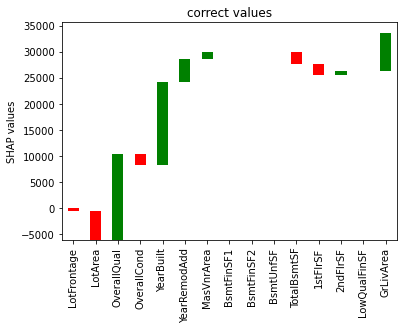

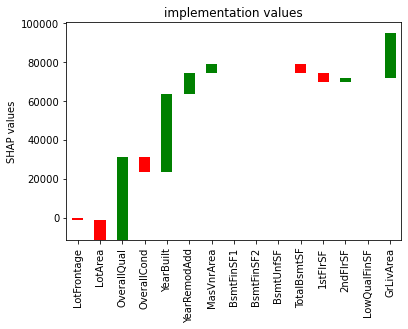

,correct values,implementation values,difference(%),correctToRef(%),implementedToRef(%)
LotFrontage,-640.75,-1121.90,42.89%,-100.35%,-100.64%
LotArea,-5505.21,-10316.30,46.64%,-103.03%,-105.92%
OverallQual,16415.71,42647.19,61.51%,-90.96%,-75.51%
OverallCond,-2091.70,-8053.33,74.03%,-101.15%,-104.62%
YearBuilt,15924.28,40491.73,60.67%,-91.23%,-76.75%
YearRemodAdd,4433.81,10709.49,58.6%,-97.56%,-93.85%
MasVnrArea,1314.87,4449.16,70.45%,-99.28%,-97.44%
BsmtFinSF1,0.00,0.00,0.0%,-100.0%,-100.0%
BsmtFinSF2,0.00,0.00,0.0%,-100.0%,-100.0%
BsmtUnfSF,0.00,0.00,0.0%,-100.0%,-100.0%


In [16]:
#Enter row from X_train for which explaination is needed
Get_Explaination(0) 

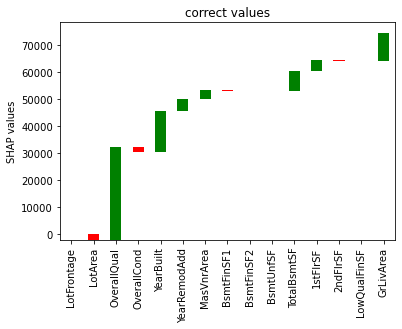

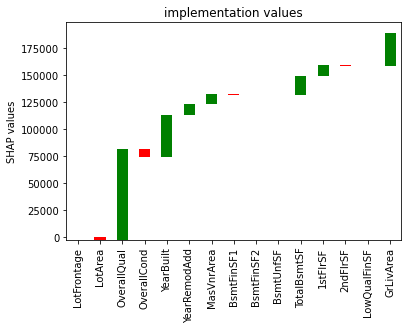

,correct values,implementation values,difference(%),correctToRef(%),implementedToRef(%)
LotFrontage,0.00,0.00,0.0%,-100.0%,-100.0%
LotArea,-2063.82,-2338.38,11.74%,-101.14%,-101.34%
OverallQual,34454.95,84466.28,59.21%,-81.03%,-51.49%
OverallCond,-2091.70,-8053.33,74.03%,-101.15%,-104.62%
YearBuilt,15370.39,39207.69,60.8%,-91.54%,-77.48%
YearRemodAdd,4189.52,10143.18,58.7%,-97.69%,-94.17%
MasVnrArea,3481.67,9472.30,63.24%,-98.08%,-94.56%
BsmtFinSF1,-422.02,-1058.17,60.12%,-100.23%,-100.61%
BsmtFinSF2,0.00,0.00,0.0%,-100.0%,-100.0%
BsmtUnfSF,0.00,0.00,0.0%,-100.0%,-100.0%


In [17]:
#Enter row from X_train for which explaination is needed
Get_Explaination(22)

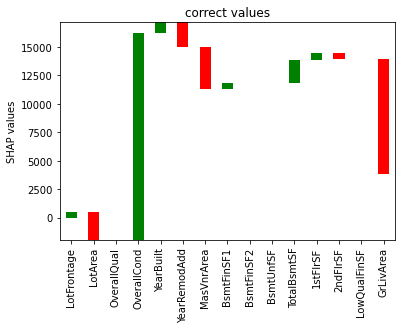

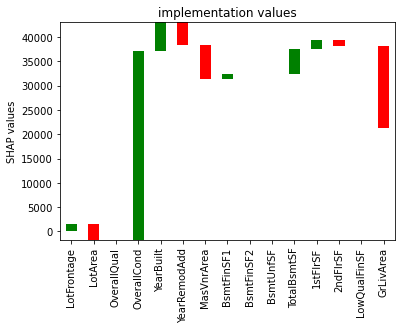

,correct values,implementation values,difference(%),correctToRef(%),implementedToRef(%)
LotFrontage,492.26,1504.69,67.28%,-99.73%,-99.14%
LotArea,-2442.05,-3215.21,24.05%,-101.34%,-101.85%
OverallQual,0.00,0.00,0.0%,-100.0%,-100.0%
OverallCond,18150.55,38872.83,53.31%,-90.01%,-77.68%
YearBuilt,969.30,5822.67,83.35%,-99.47%,-96.66%
YearRemodAdd,-2161.94,-4580.97,52.81%,-101.19%,-102.63%
MasVnrArea,-3681.53,-7133.63,48.39%,-102.03%,-104.1%
BsmtFinSF1,544.37,1182.14,53.95%,-99.7%,-99.32%
BsmtFinSF2,0.00,0.00,0.0%,-100.0%,-100.0%
BsmtUnfSF,0.00,0.00,0.0%,-100.0%,-100.0%


In [18]:
#Enter row from X_train for which explaination is needed
Get_Explaination(1)

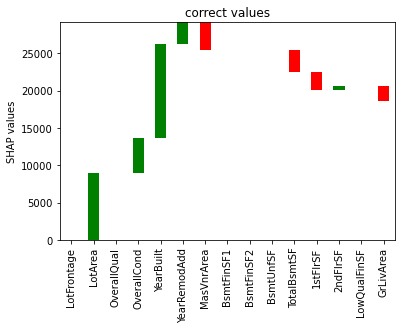

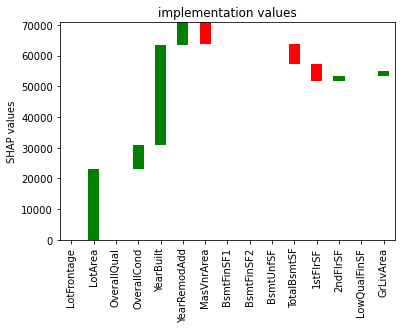

,correct values,implementation values,difference(%),correctToRef(%),implementedToRef(%)
LotFrontage,0.00,0.00,0.0%,-100.0%,-100.0%
LotArea,8928.91,23145.29,61.42%,-95.08%,-86.71%
OverallQual,0.00,0.00,0.0%,-100.0%,-100.0%
OverallCond,4655.72,7588.72,38.65%,-97.44%,-95.64%
YearBuilt,12600.95,32787.50,61.57%,-93.06%,-81.17%
YearRemodAdd,2968.09,7311.61,59.41%,-98.37%,-95.8%
MasVnrArea,-3681.53,-7133.63,48.39%,-102.03%,-104.1%
BsmtFinSF1,0.00,0.00,0.0%,-100.0%,-100.0%
BsmtFinSF2,0.00,0.00,0.0%,-100.0%,-100.0%
BsmtUnfSF,0.00,0.00,0.0%,-100.0%,-100.0%


In [19]:
#Enter row from X_train for which explaination is needed
Get_Explaination(50)